In [98]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

Load and prepare data

In [75]:
return_sequences = False

# Variables relating to the data you want to load
n = 10000
time_span = 5
c = 100
time_step = 0.1
integration_time_step = 0.01
number_timesteps_predict = 2
std = 0

In [76]:
# Load the observations
# name = f"{n}_{time_span}_{c}_{str(time_step).replace('.', '')}_{str(integration_time_step).replace('.', '')}_{std}"
name = f"{n}_{time_span}_{c}_{str(time_step).replace('.', '')}_{str(integration_time_step).replace('.', '')}_{number_timesteps_predict}_{std}"
observations = np.load(f"data_no_std/test_observations_{name}.npy")
predictions = np.load(f"data_no_std/test_predictions_{name}.npy")
print(f"observation array shape = {observations.shape}")
print(f"prediction array shape = {predictions.shape}")

observation array shape = (10000, 51, 3)
prediction array shape = (10000, 51, 3)


In [77]:
# Scale the data
maximum = max(np.max(np.abs(observations)), np.max(np.abs(predictions)))
observations_scaled = observations/maximum
predictions_scaled = predictions/maximum
print(maximum)

48.66661022527645


In [109]:
# Calculate the mean squared error between the true observation and the imperfect model's prediction
mse = (((observations_scaled[:,number_timesteps_predict:,:] - predictions_scaled[:,number_timesteps_predict:,:])**2).mean(axis=0)).mean(axis=0).mean(axis=0)
print(mse)
finalmse = (((observations_scaled[:,-1,:] - predictions_scaled[:,-1,:])**2).mean(axis=0)).mean(axis=0)
print(finalmse)

7.217840313805523e-05
6.118226431640299e-05


In [83]:
# Split into training and test data

frac = 0.9
num_samples = observations_scaled.shape[0]
cut_off = int(frac*num_samples)
timesteps_forward_predicted = 2

train_x = observations_scaled[:cut_off,:-timesteps_forward_predicted, :]
test_x = observations_scaled[cut_off:,:-timesteps_forward_predicted, :]
if return_sequences:
    train_answer = observations_scaled[:cut_off, timesteps_forward_predicted:, :]
    test_answer = observations_scaled[cut_off:, timesteps_forward_predicted:, :]
    train_prediction = predictions_scaled[:cut_off, timesteps_forward_predicted:, :]
    test_prediction = predictions_scaled[cut_off:, timesteps_forward_predicted:, :]
else:
    train_answer = observations_scaled[:cut_off, -1, :]
    test_answer = observations_scaled[cut_off:, -1, :]
    train_prediction = predictions_scaled[:cut_off, -1, :]
    test_prediction = predictions_scaled[cut_off:, -1, :]
print(f"shape of training data = {train_x.shape}")
print(f"shape of training predictions = {train_prediction.shape}")
print(f"shape of training answers = {train_answer.shape}")

shape of training data = (9000, 49, 3)
shape of training predictions = (9000, 3)
shape of training answers = (9000, 3)


Create the architecture

In [71]:
# Create the architecture
model = keras.Sequential()
model.add(layers.LSTM(64, input_shape=(None, 3), return_sequences=return_sequences))
model.add(layers.Dense(16))
model.add(layers.Dense(3))

model.summary()

model.compile(loss='mse', optimizer='adam')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 18499 (72.26 KB)
Trainable params: 18499 (72.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train

In [95]:
history = model.fit(train_x, train_answer, epochs=15, validation_data=(test_x, test_answer), batch_size=32, verbose=2, shuffle=True)

Epoch 1/15
282/282 - 6s - loss: 9.8093e-06 - val_loss: 4.5723e-06 - 6s/epoch - 22ms/step
Epoch 2/15
282/282 - 6s - loss: 4.2817e-06 - val_loss: 4.4567e-06 - 6s/epoch - 21ms/step
Epoch 3/15
282/282 - 6s - loss: 8.6095e-06 - val_loss: 3.0921e-06 - 6s/epoch - 21ms/step
Epoch 4/15
282/282 - 6s - loss: 3.6792e-06 - val_loss: 2.0585e-06 - 6s/epoch - 21ms/step
Epoch 5/15
282/282 - 7s - loss: 9.2424e-06 - val_loss: 3.8090e-06 - 7s/epoch - 24ms/step
Epoch 6/15
282/282 - 6s - loss: 1.4434e-05 - val_loss: 2.1809e-06 - 6s/epoch - 21ms/step
Epoch 7/15
282/282 - 6s - loss: 2.9676e-06 - val_loss: 4.3548e-06 - 6s/epoch - 21ms/step
Epoch 8/15
282/282 - 10s - loss: 1.0868e-05 - val_loss: 1.0074e-05 - 10s/epoch - 37ms/step
Epoch 9/15
282/282 - 11s - loss: 5.4412e-06 - val_loss: 3.7166e-06 - 11s/epoch - 40ms/step
Epoch 10/15
282/282 - 8s - loss: 2.4915e-06 - val_loss: 2.4428e-06 - 8s/epoch - 28ms/step
Epoch 11/15
282/282 - 7s - loss: 2.6703e-06 - val_loss: 3.1198e-06 - 7s/epoch - 25ms/step
Epoch 12/15
282

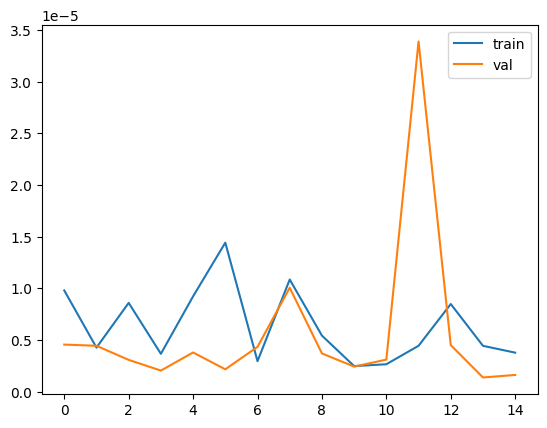

In [97]:
# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [85]:
ML_predictions = model.predict(test_x)
print(ML_predictions.shape)

32/32 [==============================] - 1s 11ms/step
(1000, 3)


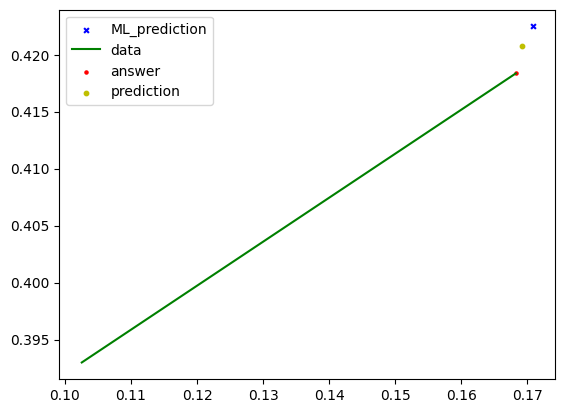

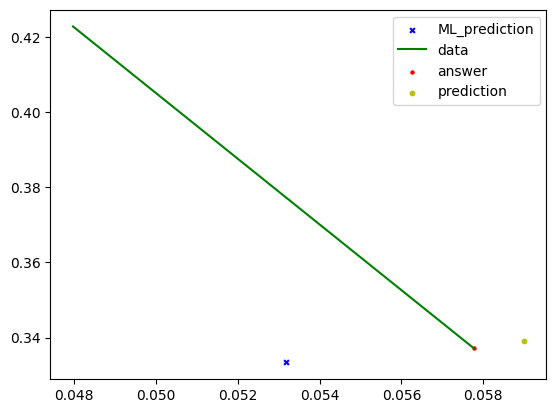

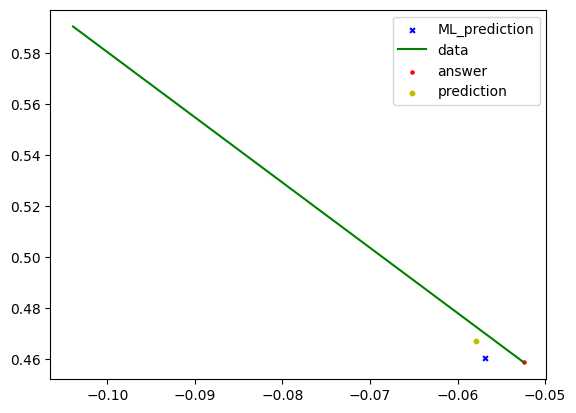

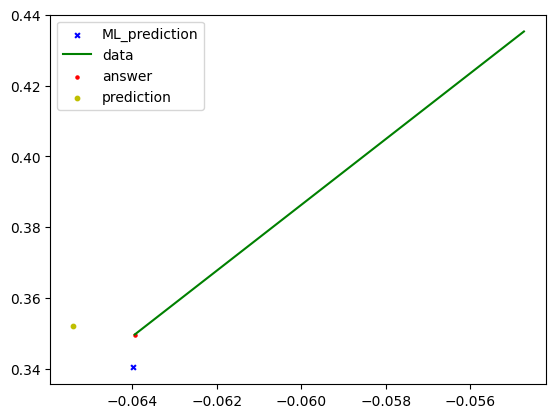

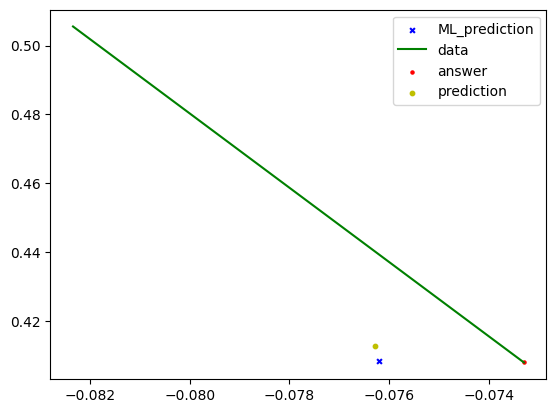

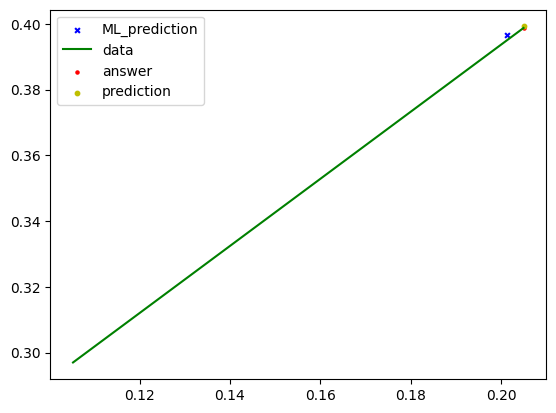

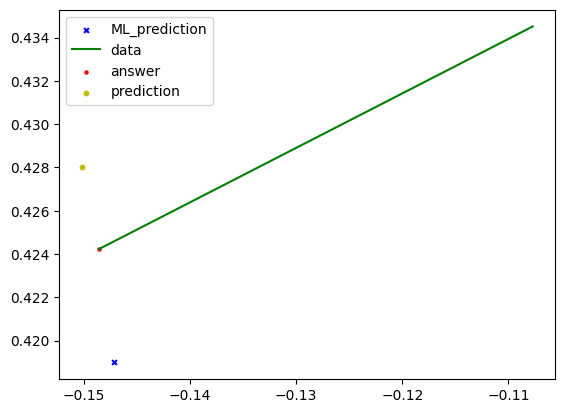

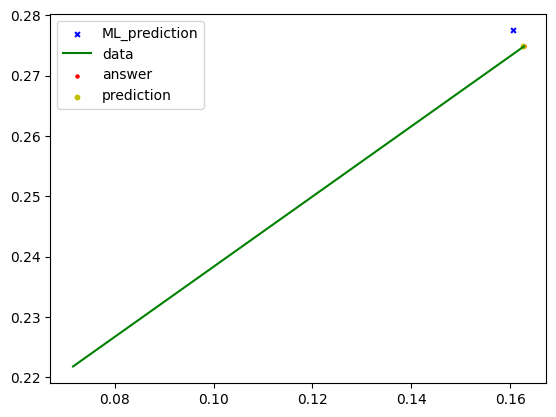

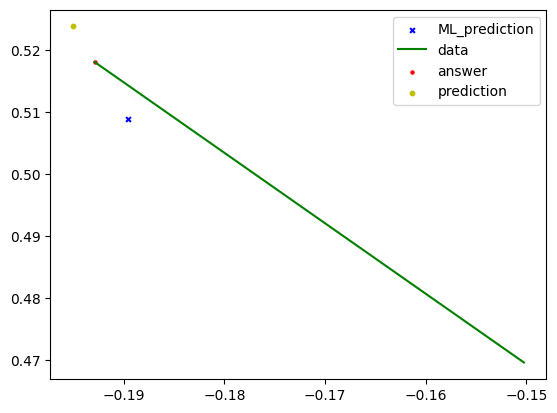

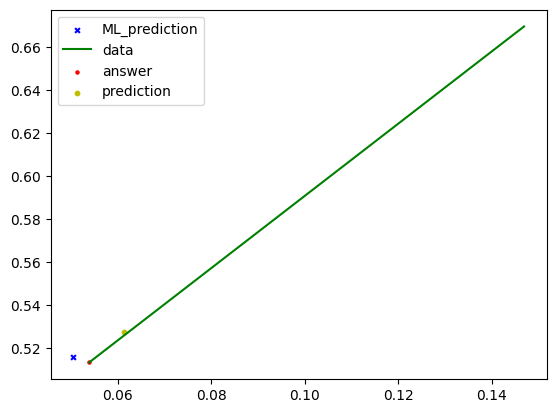

In [106]:
a = 0
b = 2
for i in range(200,210,1):
    plt.scatter(ML_predictions[i,a], ML_predictions[i,b], label = 'ML_prediction', s=12, marker ='x', color = 'b')
    # plt.plot(test_x[i,:,a], test_x[i,:,b], label = 'data', color = 'g')
    plt.plot(observations_scaled[9000+i,-2:,a], observations_scaled[9000+i,-2:,b], label = 'data', color = 'g')
    plt.scatter(test_answer[i,a], test_answer[i,b], label = 'answer', s=5, color = 'r')
    plt.scatter(test_prediction[i,a], test_prediction[i,b], label = 'prediction', s=10, color = 'y', marker ='o')
    plt.legend()
    plt.show()

Save!

In [96]:
model.save(f'saved_models/timesteps_{number_timesteps_predict}/ML_only_data_{name}.keras')